In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from tqdm import tqdm
import sys 

sys.path.append('../')
sys.path.append('../src/')

from src.utils import run_exps
from src.detection import DataCopyingDetector, ThreeSampleDetector
from src.generative import *

# Majority Voting

**Idea:** Until now we classified a data point as copied if in _any_ projection it is classified as copied. This seems to be a bit too strict. We can relax this condition by requiring that a data point is classified as copied if it is classified as copied in _most_ - or sufficiently many - projections. The idea behind this is that a data copy should be close to the original in almost all projections. We can tune the number of projections that need to classify a data point as copied by setting a threshold. 

In this notebook, we want to explore this algorithm throughout different datasets while manipulating the dimensionality of the target space and the number of projections.

## Sphere

### $d_{proj} = 2$

In [2]:
d_proj = 2
true_cr = 0.4
k = 100
N_train = 20000
N_test = 20000
ds = [5, 10, 20, 50]
ps = [Sphere(d=d) for d in ds]
Xs = [p.sample(N_train) for p in ps]
qs = [Mixture(rho=true_cr, q1=Memorizer(), q2=Memorizer(radius=0.25, n_copying=len(X))).fit(X) for X in Xs]
det = DataCopyingDetector()
X1_gens = [q.sample(N_test) for q in qs]
X2_gens = [q.sample(N_test) for q in qs]

# create np array to store the results (shape = (N_test, k, len(ds)))
results_sphere_2D = np.zeros((N_test, k, len(ds))).astype(bool)

for i, (p, q, X1_gen, X2_gen) in enumerate(zip(ps, qs, X1_gens, X2_gens)):
    for j in tqdm(range(k)):
        rp = GaussianRandomProjection(n_components=d_proj)
        rp.fit(Xs[i])
        X_proj = rp.transform(Xs[i])
        X1_gen_proj = rp.transform(X1_gen)
        X2_gen_proj = rp.transform(X2_gen)
        idx = det.get_copying_indices(X_proj, X1_gen_proj, X2_gen_proj)
        results_sphere_2D[idx, j, i] = True

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


In [3]:
# output the majority aggregation for each d
for i, d in enumerate(ds):
    print(f"d = {d}")
    majority_agg = (results_sphere_2D[:, :, i].sum(axis=1) > k/2).mean()
    print(f"theoretical copying rate: {true_cr}")
    print(f"majority aggregation: {majority_agg}")
    print(f"Set aggregation: {results_sphere_2D[:, :, i].any(axis=1).mean()}")
    print("")
    print("")

d = 5
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.88025


d = 10
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.87935


d = 20
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.8699


d = 50
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.87295




We observe: Majority Voting outputs always the true copying rate. 

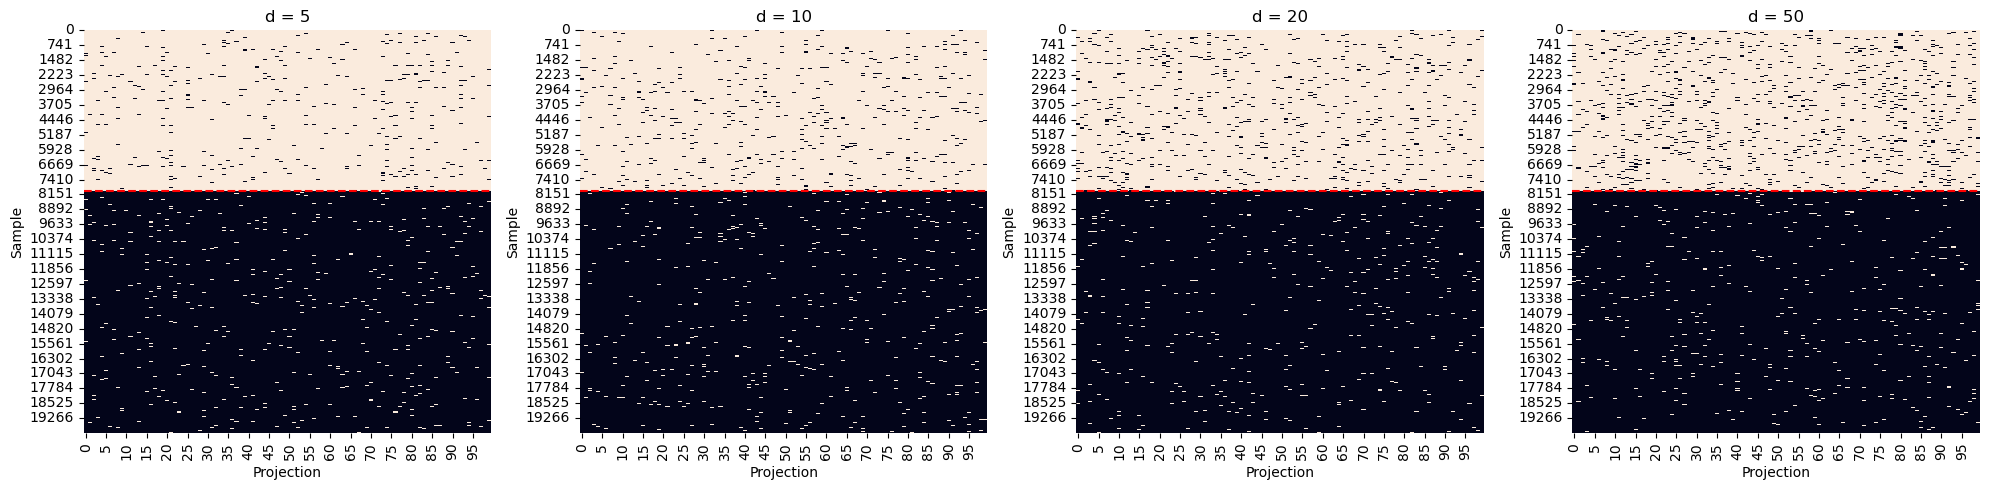

In [4]:
# create heatmap for each d
fig, axs = plt.subplots(1, len(ds), figsize=(20, 5))
for i, d in enumerate(ds):
    sns.heatmap(results_sphere_2D[:, :, i], ax=axs[i], cbar=False)
    axs[i].set_title(f"d = {d}")
    axs[i].axhline(N_test * true_cr, color='r', linestyle='--')
    axs[i].set_xlabel("Projection")
    axs[i].set_ylabel("Sample")
    
plt.tight_layout()
plt.show()

### $d_{proj} = 1$

In [5]:
true_cr = 0.4
d_proj = 1
ds = [5, 10, 20, 50]
ps = [Sphere(d=d) for d in ds]
Xs = [p.sample(N_train) for p in ps]
qs = [Mixture(rho=true_cr, q1=Memorizer(), q2=Memorizer(radius=0.25, n_copying=len(X))).fit(X) for X in Xs]
det = DataCopyingDetector()
X1_gens = [q.sample(N_test) for q in qs]
X2_gens = [q.sample(N_test) for q in qs]

# create np array to store the results (shape = (N_test, k, len(ds)))
results_sphere_1D = np.zeros((N_test, k, len(ds))).astype(bool)

for i, (p, q, X1_gen, X2_gen) in enumerate(zip(ps, qs, X1_gens, X2_gens)):
    for j in tqdm(range(k)):
        rp = GaussianRandomProjection(n_components=d_proj)
        rp.fit(Xs[i])
        X_proj = rp.transform(Xs[i])
        X1_gen_proj = rp.transform(X1_gen)
        X2_gen_proj = rp.transform(X2_gen)
        idx = det.get_copying_indices(X_proj, X1_gen_proj, X2_gen_proj)
        results_sphere_1D[idx, j, i] = True

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


In [6]:
for i, d in enumerate(ds):
    print(f"d = {d}")
    majority_agg = (results_sphere_1D[:, :, i].sum(axis=1) > k/2).mean() # above 50% of the projections
    print(f"theoretical copying rate: {true_cr}")
    print(f"majority aggregation: {majority_agg}")
    print(f"Set aggregation: {results_sphere_1D[:, :, i].any(axis=1).mean()}")
    print("")
    print("")

d = 5
theoretical copying rate: 0.4
majority aggregation: 0.0
Set aggregation: 0.2506


d = 10
theoretical copying rate: 0.4
majority aggregation: 0.0
Set aggregation: 0.3461


d = 20
theoretical copying rate: 0.4
majority aggregation: 0.0
Set aggregation: 0.3785


d = 50
theoretical copying rate: 0.4
majority aggregation: 0.0
Set aggregation: 0.4252




__Observations:__ In 1 Dimension this does not work.

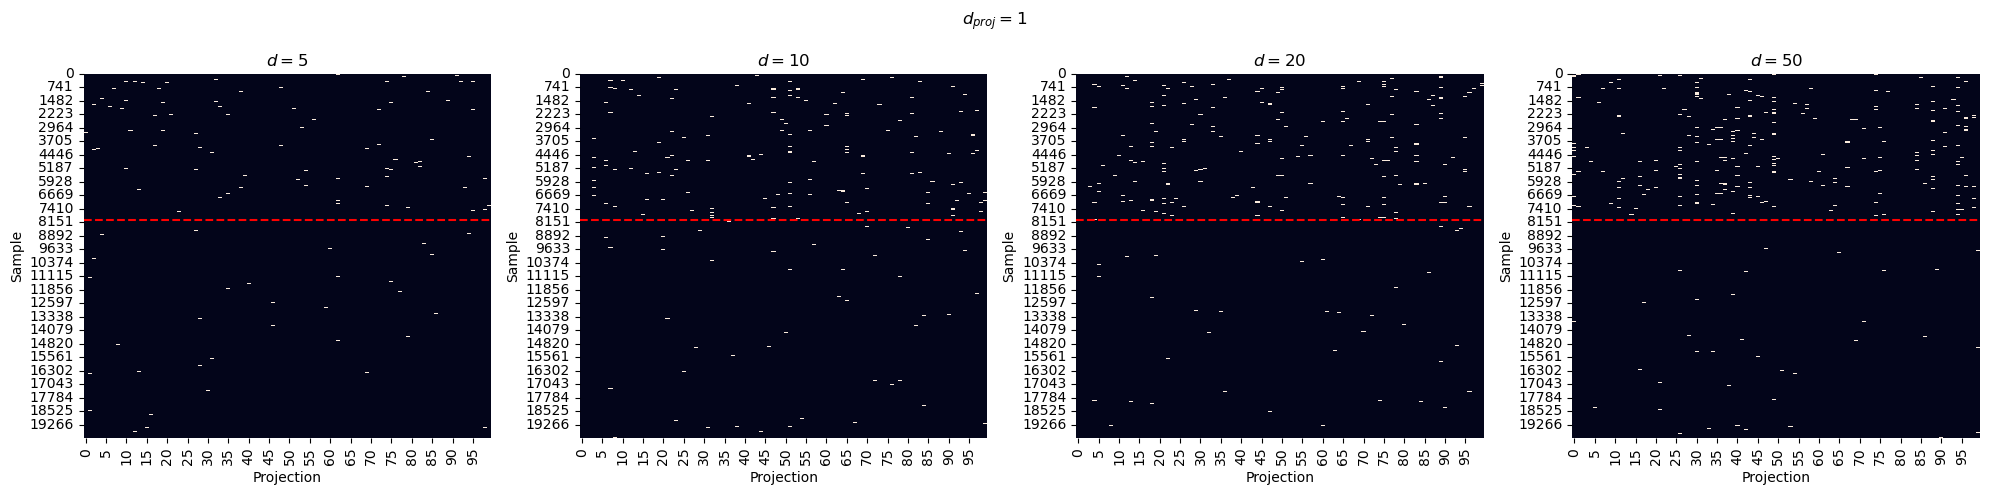

In [7]:
fig, axs = plt.subplots(1, len(ds), figsize=(20, 5))
fig.suptitle("$d_{proj} = 1$")

for i, d in enumerate(ds):
    sns.heatmap(results_sphere_1D[:, :, i], ax=axs[i], cbar=False)
    axs[i].set_title(f"$d = {d}$")
    axs[i].axhline(N_test * true_cr, color='r', linestyle='--')
    axs[i].set_xlabel("Projection")
    axs[i].set_ylabel("Sample")

plt.tight_layout()
plt.show()

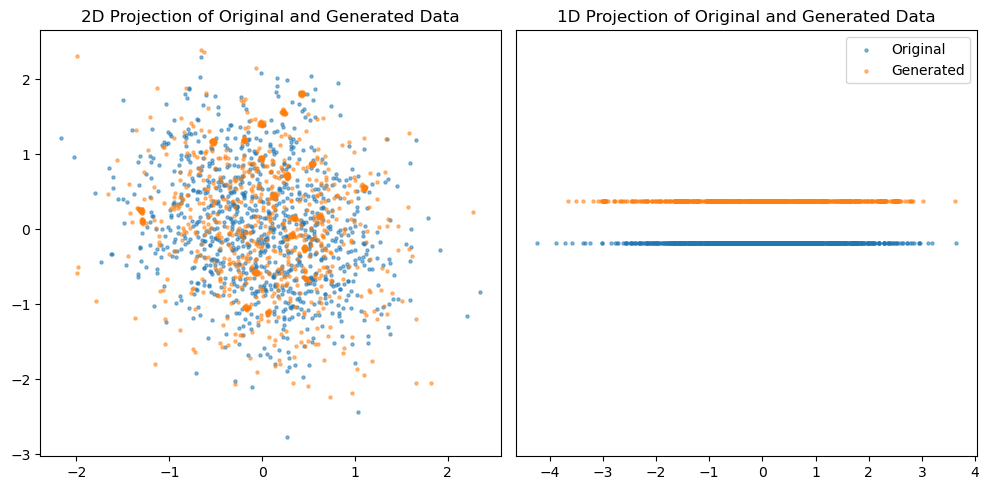

In [9]:
# plot one example embedding
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
rp = GaussianRandomProjection(n_components=2)
X_plot = rp.fit_transform(ps[-1].sample(1000))
X_gen_plot = rp.transform(qs[-1].sample(1000))
axs[0].scatter(X_plot[:, 0], X_plot[:, 1], label="Original", alpha=0.5, s=5)
axs[0].scatter(X_gen_plot[:, 0], X_gen_plot[:, 1], label="Generated", alpha=0.5, s=5)
axs[0].set_title("2D Projection of Original and Generated Data")

rp = GaussianRandomProjection(n_components=1)
X_plot = rp.fit_transform(ps[-1].sample(1000))
X_gen_plot = rp.transform(qs[-1].sample(1000))

axs[1].scatter(X_plot, np.zeros_like(X_plot), label="Original", alpha=0.5, s=5)
axs[1].scatter(X_gen_plot, np.zeros_like(X_gen_plot) + 0.02, label="Generated", alpha=0.5, s=5)
axs[1].set_yticks([])
axs[1].set_ylim(-0.1, 0.1)
axs[1].set_title("1D Projection of Original and Generated Data")
plt.legend()
plt.tight_layout()
plt.show()

## Multivariate Gaussians

### $d_{proj} = 2$

In [10]:
true_cr = 0.4
d_proj = 2
ds = [5, 10, 20, 50]
Xs = [np.random.multivariate_normal(np.zeros(d), np.eye(d), N_train) for d in ds]
qs = [Mixture(rho=true_cr, q1=Memorizer(), q2=Memorizer(radius=0.25, n_copying=len(X))).fit(X) for X in Xs]
det = DataCopyingDetector()
X1_gens = [q.sample(N_test) for q in qs]
X2_gens = [q.sample(N_test) for q in qs]


results_mvg_2D = np.zeros((N_test, k, len(ds))).astype(bool)

for i, (d, q, X1_gen, X2_gen) in enumerate(zip(ds, qs, X1_gens, X2_gens)):
    for j in tqdm(range(k)):
        rp = GaussianRandomProjection(n_components=d_proj)
        rp.fit(Xs[i])
        X_proj = rp.transform(Xs[i])
        X1_gen_proj = rp.transform(X1_gen)
        X2_gen_proj = rp.transform(X2_gen)
        idx = det.get_copying_indices(X_proj, X1_gen_proj, X2_gen_proj)
        results_mvg_2D[idx, j, i] = True

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


In [11]:
for i, d in enumerate(ds):
    print(f"d = {d}")
    majority_agg = (results_mvg_2D[:, :, i].sum(axis=1) > 2*k/3).mean() # two thirds majority
    print(f"theoretical copying rate: {true_cr}")
    print(f"majority aggregation: {majority_agg}")
    print(f"Set aggregation: {results_mvg_2D[:, :, i].any(axis=1).mean()}")
    print("")
    print("")

d = 5
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.8398


d = 10
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.8387


d = 20
theoretical copying rate: 0.4
majority aggregation: 0.4
Set aggregation: 0.8338


d = 50
theoretical copying rate: 0.4
majority aggregation: 0.4002
Set aggregation: 0.835




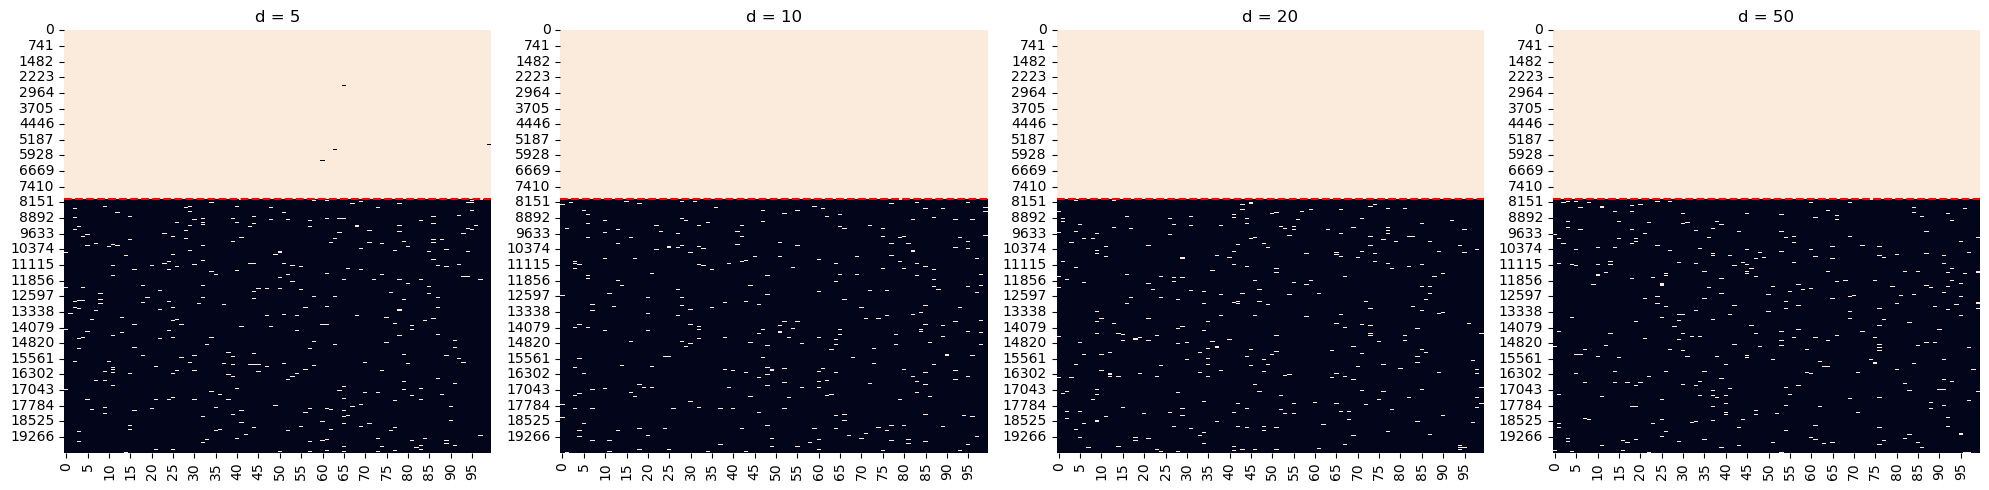

In [12]:
fig, axs = plt.subplots(1, len(ds), figsize=(20, 5))
for i, d in enumerate(ds):
    sns.heatmap(results_mvg_2D[:, :, i], ax=axs[i], cbar=False)
    axs[i].set_title(f"d = {d}")
    axs[i].axhline(true_cr*N_test, color='red', linestyle='--')

plt.tight_layout()
plt.show()

### $d_{proj} = 1$

In [13]:
d_proj = 1

results_mvg_1D = np.zeros((N_test, k, len(ds))).astype(bool)

for i, (d, q, X1_gen, X2_gen) in enumerate(zip(ds, qs, X1_gens, X2_gens)):
    for j in tqdm(range(k)):
        rp = GaussianRandomProjection(n_components=d_proj)
        rp.fit(Xs[i])
        X_proj = rp.transform(Xs[i])
        X1_gen_proj = rp.transform(X1_gen)
        X2_gen_proj = rp.transform(X2_gen)
        idx = det.get_copying_indices(X_proj, X1_gen_proj, X2_gen_proj)
        results_mvg_1D[idx, j, i] = True

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


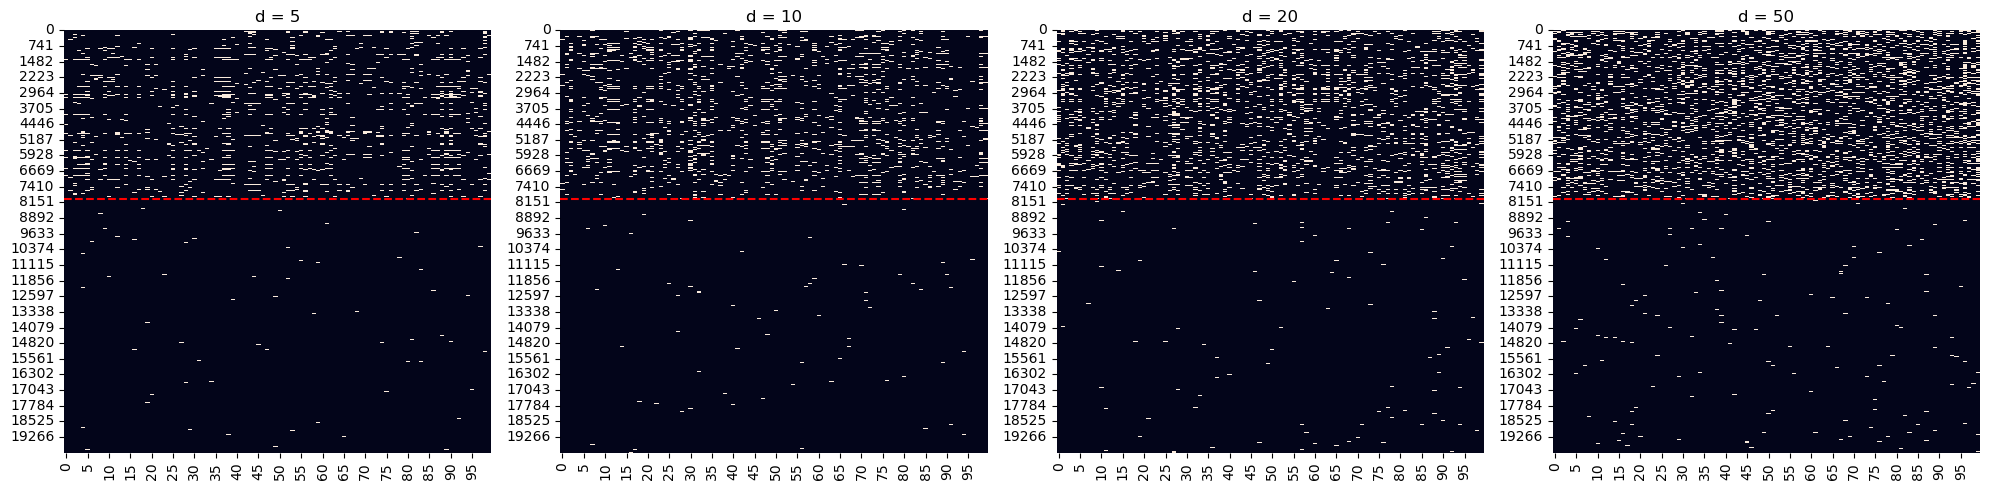

In [14]:
fig, axs = plt.subplots(1, len(ds), figsize=(20, 5))
for i, d in enumerate(ds):
    sns.heatmap(results_mvg_1D[:, :, i], ax=axs[i], cbar=False)
    axs[i].set_title(f"d = {d}")
    axs[i].axhline(true_cr*N_test, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [15]:
for i, d in enumerate(ds):
    print(f"d = {d}")
    majority_agg = (results_mvg_1D[:, :, i].sum(axis=1) > k/33).mean() # over 3% 
    print(f"theoretical copying rate: {true_cr}")
    print(f"majority aggregation: {majority_agg}")
    print(f"Set aggregation: {results_mvg_1D[:, :, i].any(axis=1).mean()}")
    print("")
    print("")

d = 5
theoretical copying rate: 0.4
majority aggregation: 0.1784
Set aggregation: 0.4774


d = 10
theoretical copying rate: 0.4
majority aggregation: 0.28135
Set aggregation: 0.53715


d = 20
theoretical copying rate: 0.4
majority aggregation: 0.37505
Set aggregation: 0.58565


d = 50
theoretical copying rate: 0.4
majority aggregation: 0.40025
Set aggregation: 0.63015




## Halfmoons

In [16]:
cr_true = 0.4
N_train = 20000
N_test = 20000
k = 1000 # number of projections
p = Halfmoons(noise=0.1)
X = p.sample(N_train)
q = Mixture(rho=cr_true, q1=Memorizer(), q2=Memorizer(radius=0.25, n_copying=len(X))).fit(X)
det = DataCopyingDetector()
X1_gen = q.sample(N_test)
X2_gen = q.sample(N_test)

df_hf = pd.DataFrame(np.zeros((len(X2_gen), k)), columns=[f'proj_{i}' for i in range(k)]).astype(bool)

for i in tqdm(range(k)):
    rp = GaussianRandomProjection(n_components=1)
    rp.fit(X)
    X_proj = rp.transform(X)
    X1_gen_proj = rp.transform(X1_gen)
    X2_gen_proj = rp.transform(X2_gen)
    idx = det.get_copying_indices(X_proj, X1_gen_proj, X2_gen_proj)
    df_hf.loc[idx, f'proj_{i}'] = True

100%|██████████| 1000/1000 [12:47<00:00,  1.30it/s]


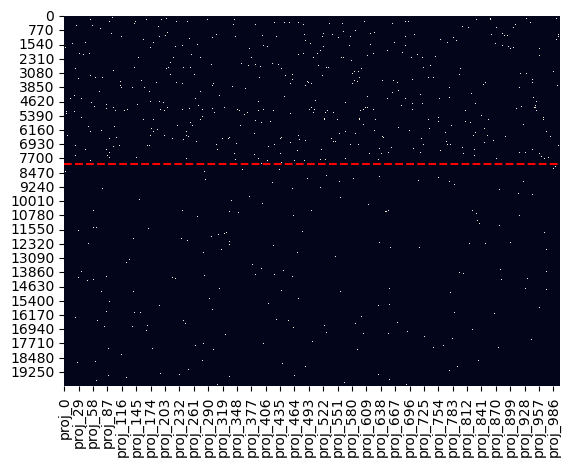

In [17]:
sns.heatmap(df_hf, cbar=False)
plt.hlines(N_test * cr_true, 0, k, color='r', linestyle='--')
plt.show()

**Observation:** No structure in plot. Seems "lucky" which points are classified as copied. The more random projections we use, the more likely we are to classify a point as copied. 

In [18]:

# set, i.e. for any column i, if there is at least one True, then the column is True
set_agg = df_hf.any(axis=1).mean()
print(f"set aggregation: {set_agg}")

# mean
mean_agg = (df_hf.mean(axis=0)).mean()
print(f"mean aggregation: {mean_agg}")

# median
median_agg = (df_hf.mean(axis=0)).median()
print(f"median aggregation: {median_agg}")

# maximum
max_agg = (df_hf.mean(axis=0)).max()
print(f"max aggregation: {max_agg}")

# minimum
min_agg = (df_hf.mean(axis=0)).min()
print(f"min aggregation: {min_agg}")

print("--> any other quantile is between the two values above")

# majority, i.e. for any column i, if the majority of the column is True, then the column is True
majority_agg = (df_hf.sum(axis=1) > k/500).mean() # only 0.2% of the projections have to be True
print(f"majority aggregation: {majority_agg}")

set aggregation: 0.8635
mean aggregation: 0.0032331000000000005
median aggregation: 0.00315
max aggregation: 0.0061
min aggregation: 0.0016
--> any other quantile is between the two values above
majority aggregation: 0.4722


In [19]:
det.estimate_cr(X, q, N_test, type="original")

0.4031

In [20]:
# artificially blow up the dimensionality by stacking the data couple of times (column-wise)
X = np.hstack([X]*25)
X1_gen = np.hstack([X1_gen]*25)
X2_gen = np.hstack([X2_gen]*25)

k = 100
df_hf = pd.DataFrame(np.zeros((len(X2_gen), k)), columns=[f'proj_{i}' for i in range(k)]).astype(bool)

for i in tqdm(range(k)):
    rp = GaussianRandomProjection(n_components=1)
    rp.fit(X)
    X_proj = rp.transform(X)
    X1_gen_proj = rp.transform(X1_gen)
    X2_gen_proj = rp.transform(X2_gen)
    idx = det.get_copying_indices(X_proj, X1_gen_proj, X2_gen_proj)
    df_hf.loc[idx, f'proj_{i}'] = True

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


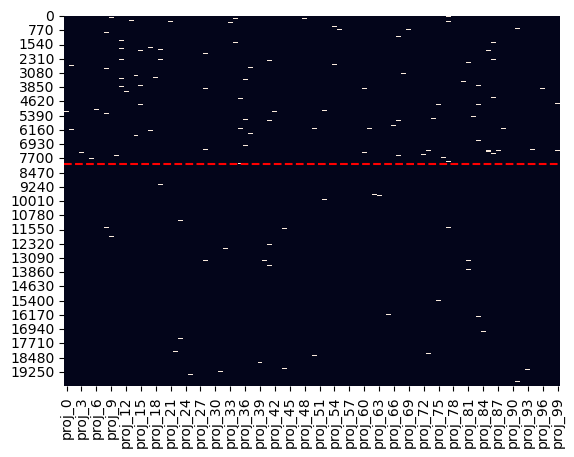

In [21]:
sns.heatmap(df_hf, cbar=False)
plt.hlines(N_test * cr_true, 0, k, color='r', linestyle='--')
plt.show()